## Decoding using Machine Learning

The following notebook compares forward-error correction algorithms using multinomial logistic regression. The algorithms are compared over various levels of SNR in the signal transmission, in terms of their bit-error rate and block-error rate.

Note: The cookbook and encode functions were written by Professor Benammar of ISAE-SUPAERO as part of the Information Engineering course of the M.Sc. in Aerospace Engineering program.

In [300]:
import numpy as np  
import matplotlib.pyplot as plt  
import scipy.signal as ss
import numpy as np
import scipy as sp
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import itertools
plt.rcParams['figure.dpi']= 140

In [2]:
i_code = 4

Codebook for a given generator function, like Hamming, BKLC etc.

In [3]:
def create_codebook(G):
    k= G.shape[0] # number of input bits
    n= G.shape[1] # number of output bits 
    # Obtain all possible binary words of length k
    int_array = np.arange(0,2**k,dtype= np.uint8).reshape(( 2**k,1))
    bin_matrix = np.unpackbits(int_array,axis=1)
    bin_words = bin_matrix[:,8-k:8]
    codebook= np.zeros((2**k,n), dtype=float)
    for i_word in range(0,2**k):
            codebook[i_word,:]= np.mod(bin_words[i_word,:].dot(G), 2) 
    return [codebook,bin_words]   

Encoding function

In [4]:
def encode(b, G):  
    n= G.shape[1] # size of each codeword  
    N_blocks = b.shape[0] # number of codewords
    c = np.zeros((N_blocks,n), dtype=float)
    for i_block in range(0,N_blocks):
        c[i_block,:]= np.mod(b[i_block,:].dot(G), 2) 
    return c 

Logistic regression training

In [153]:
def Reg_train(G, m):
    num_simus = 10000
    k = G.shape[0] # number of input bits
    n = G.shape[1] # number of output bits 
    EbN0 = 0
    binary_messages = np.random.randint(0,2,size=(num_simus,k))
    coded_messages = encode(binary_messages,G)
    signal_transm = -2*coded_messages + 1
    sigma  = np.sqrt(float(1)/2/((k/n)*10**(EbN0/10)))
    Noise = sigma*np.random.standard_normal(signal_transm.shape)
    signal_receiv = signal_transm + Noise
    
    #putting the binaries in a list so that Y in the model has one element per row
    bn = []
    for i in range(0,len(binary_messages)):
        bn.append(binary_messages[i][m])
    clf = LogisticRegression(random_state=0).fit(signal_receiv, bn)
    return clf

Prediction and error calculation for one generator function and one binary outcome

In [170]:
def main(G, m, clf):
    num_simus = 1000000
    k = G.shape[0] # number of input bits
    n = G.shape[1] # number of output bits 
    [codebook, messages] = create_codebook(G)
    EbN0_dB_start = 0
    EbN0_dB_stop  = 10
    EbN0_points = 11
    EbN0 = np.linspace(EbN0_dB_start ,EbN0_dB_stop ,EbN0_points) 
    errs_MAP = []
    for i_EbN0 in range(0,len(EbN0)): 
    
    # SMessage source  
        binary_messages = np.random.randint(0,2,size=(num_simus,k)) 
        bn = []
        for i in range(0,len(binary_messages)):
            bn.append(binary_messages[i][m])
    # Encoder
        coded_messages = encode(binary_messages,G)
    
    # Modulator (BPSK)
        signal_transm = -2*coded_messages + 1

    # Channel (AWGN)
    # Compute the variance of the noise
        sigma  = np.sqrt(float(1)/2/((k/n)*10**(EbN0[i_EbN0]/10))) 
    # Generate the noise
        Noise = sigma*np.random.standard_normal(signal_transm.shape)
    # Add the noise
        signal_receiv = signal_transm + Noise        
        
    #Logistic regression prediction 
    #This method is trained to take in the received signal that has k columns (7 for Hamming, 9 for BKCL etc)
    #and output a predicted list of binary (0,1) message. We compare the predicted list with the
    #original binary message.
        res = list(clf.predict(signal_receiv))

    #Compute errors
        errs = []
        for i in range(0,len(res)):
            errs.append(abs(res[i]-bn[i]))
        errs_MAP.append(errs)
    return errs_MAP

Prediction and error calculation for one generator function and multiple binary outcomes

In [283]:
def main_main(G):
    
    k = G.shape[0] # number of input bits
    n = G.shape[1] # number of input bits
    errors = []
    bl_errors = [True]*1000000
    for j in range(0,k):
        clf= Reg_train(G,j)
        errors.append(main(G,j,clf))
    bl_tot = []
    er_tot = []
    nb_tot = []
    ##Basically data manipulations so that we put the errors in the correct arrays and such
    ##It got complicated with matrix transpose etc, and I allowed this to add a few minutes to the 
    ##processing time so that I have a clear picture of what is going on.
    for l in range(0,11):
        bl_tot.append([0]*1000000)
        er_tot.append(sum(errors[0][l]))
        for i in range(0,1000000):
            bl_tot[l][i] = 0
            for a in range(0,k):
                bl_tot[l][i] = bl_tot[l][i] + errors[a][l][i]
            temp = (int(bl_tot[l][i]) != 0)
            bl_tot[l][i] = int(temp)
        nb_tot.append(sum(bl_tot[l]))
    return er_tot, nb_tot

Prediction and error calculation for multiple generator functions. Plots of relevant graphs

In [337]:
def main_main_main(Gs,labels):
    ##Just plots everything
    
    num_simus = 1000000
    EbN0_dB_start = 0
    EbN0_dB_stop  = 10
    EbN0_points = 11
    EbN0 = np.linspace(EbN0_dB_start ,EbN0_dB_stop ,EbN0_points) 
    BERs = []
    BLERs = []
    for h in range(0,len(Gs)):
        print(labels[h])
        print("")
        G = Gs[h]
        k = G.shape[0]
        n = G.shape[1]
        er_tot,nb_tot = main_main(G)
        BERs.append(np.array(er_tot)/(k*num_simus))
        BLERs.append(np.array(nb_tot)/(k*num_simus))
        BER =  np.array(er_tot)/(k*num_simus)
        BLER = np.array(nb_tot)/(k*num_simus) 
        print("X-Band BER  :",BER[0])
        print("       BLER :",BLER[0])
        print("UHF-Band BER  :",BER[8])
        print("         BLER :",BLER[8])
        plt.plot(EbN0, BER, label = str(labels[h] + " BER"))  
        plt.plot(EbN0, BLER, label = str(labels[h] + " BLER"))
        plt.legend()
        plt.yscale('log')
        plt.xlabel('$E_b/N_0$')
        plt.ylabel('Error Rate')    
        plt.grid(True)
        plt.show()
    for h in range(0,len(Gs)):
        plt.plot(EbN0, BERs[h], label = str(labels[h] + " BER"))  
        plt.legend()
        plt.yscale('log')
        plt.xlabel('$E_b/N_0$')
        plt.ylabel('Error Rate')    
        plt.grid(True)
    plt.show()
    for h in range(0,len(Gs)):
        plt.plot(EbN0, BLERs[h], label = str(labels[h] + " BLER"))
        plt.legend()
        plt.yscale('log')
        plt.xlabel('$E_b/N_0$')
        plt.ylabel('Error Rate')
        plt.grid(True)
    plt.show()

Hamming

X-Band BER  : 0.035611
       BLER : 0.11477725
UHF-Band BER  : 0.0009385
         BLER : 0.00365125


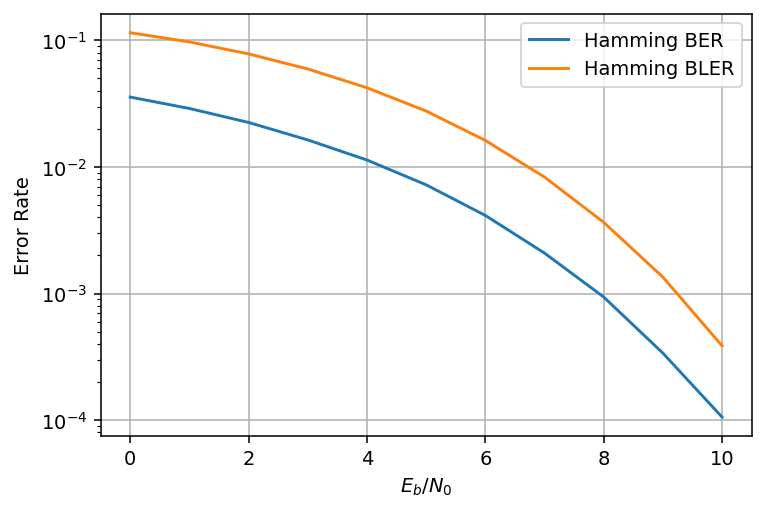

Repetition

X-Band BER  : 0.078979
       BLER : 0.078979
UHF-Band BER  : 0.000201
         BLER : 0.000201


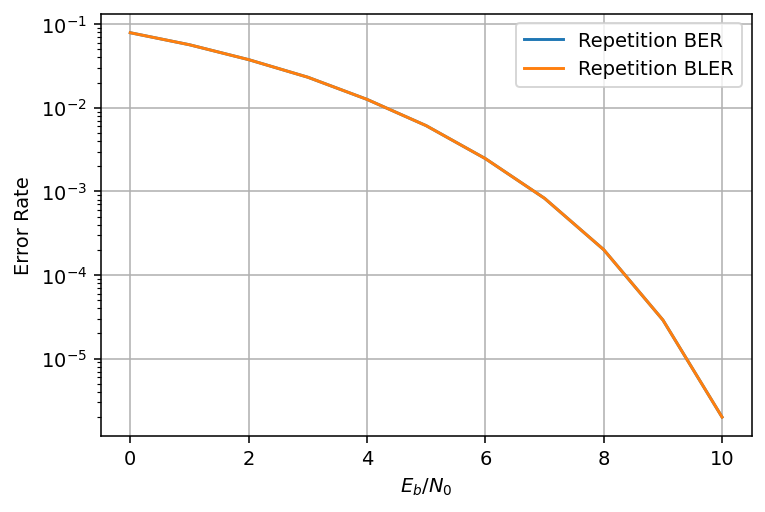

BKLC

X-Band BER  : 0.06896
       BLER : 0.167317
UHF-Band BER  : 0.006832666666666667
         BLER : 0.020091666666666667


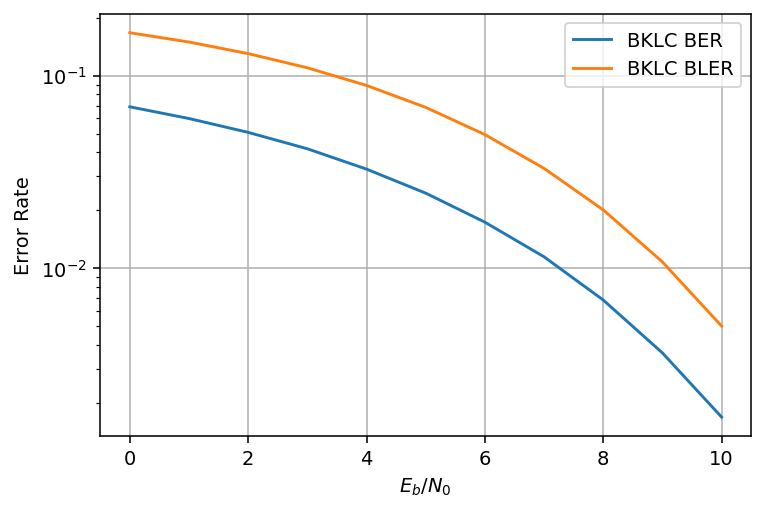

No Code

X-Band BER  : 0.07867
       BLER : 0.07867
UHF-Band BER  : 0.00022
         BLER : 0.00022


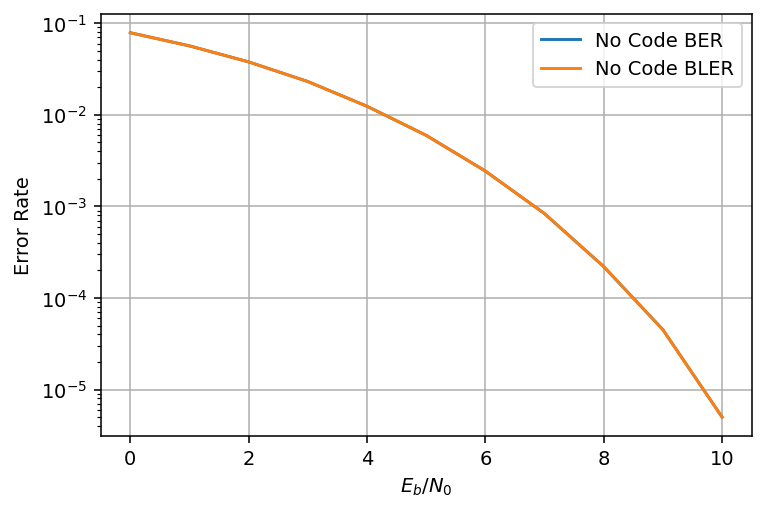

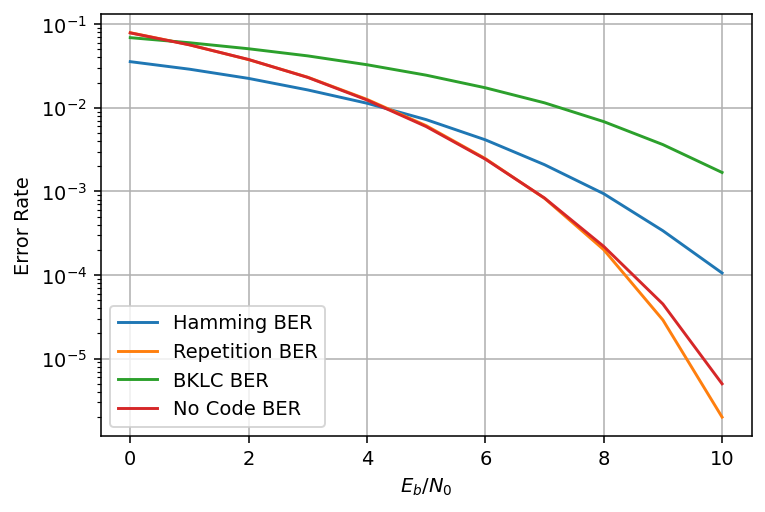

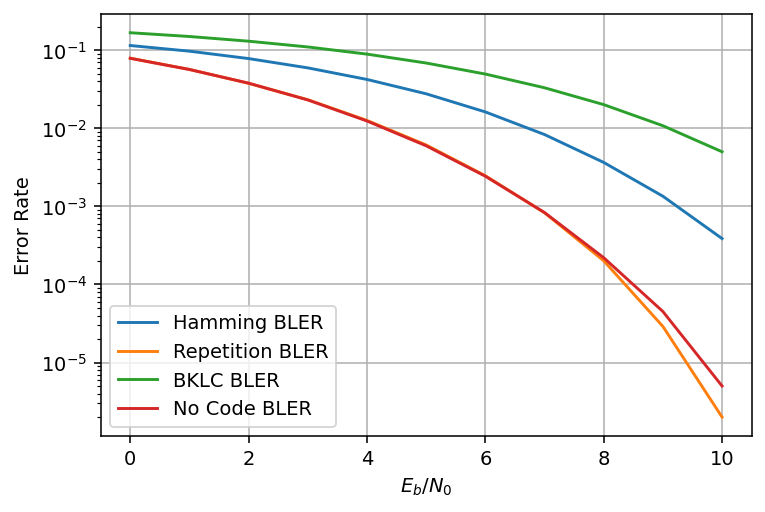

In [338]:
G_Hamming = np.array([[1, 0, 0, 0, 1, 1, 0], [0, 1, 0, 0, 1, 0, 1], [0, 0, 1, 0, 0, 1, 1], [0, 0, 0, 1, 1, 1, 1]])
G_Repetition = np.array([[1,1,1]])
G_BKLC = np.array([[1, 0, 0, 1, 0, 1, 1, 0, 0], [0, 1, 0, 1, 0, 1, 0, 1, 0], [0, 0, 1, 1, 0, 0, 1, 1, 0]])
G_no_code = np.array([[1]])
Gs = [G_Hamming,G_Repetition,G_BKLC,G_no_code]
labels = ['Hamming', 'Repetition', 'BKLC','No Code']
main_main_main(Gs,labels)